In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as appl
from sklearn.model_selection import train_test_split
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from keras import callbacks  
from keras.models import load_model
from keras.utils import np_utils

In [2]:
load_path = 'E:/VA/onehandtwohand/128/massey_H/'

In [3]:
CATEGORIES=np.load(load_path+'cat_massey.npy', allow_pickle=True)

In [4]:
# CATEGORIES=['antelope', 'bag', 'book', 'bottle', 'colour', 'dolphin', 'dupatta', 'fast', 'fish', 'frog', 'gun',
#             'hair', 'help', 'idea', 'internet', 'jeans', 'location', 'owl', 'pen', 'photo', 'rain', 'saree', 'school',
#             'shoot', 'sun', 'technology', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'
#             , 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'accept', 'age', 'assistant', 'black', 'boot', 'card', 'cash',
#             'chicken', 'dance', 'earpods', 'handkerchief', 'home', 'human', 'keep', 'laptop', 'meet', 'mobile', 'monkey',
#             'namastey', 'person', 'proof', 'signature', 'sleep', 'spider', 'stand', 'star', 'tv', 'umbrella', 'white',
#             'wolf', 'yellow']

In [5]:
# # get categories in dataset
# TRAIN_DIR = "D:/VA/25words_DSLR"
# CATEGORIES = []
# for img in tqdm(os.listdir(TRAIN_DIR)):
#     CATEGORIES.append(img)
# TRAIN_DIR = "D:/VA/26words_DSLR"
# for img in tqdm(os.listdir(TRAIN_DIR)):
#     CATEGORIES.append(img)

# TRAIN_DIR = "D:/VA/31words_DSLR"
# for img in tqdm(os.listdir(TRAIN_DIR)):
#     CATEGORIES.append(img)

#     # exclude situation
# npys=['X.npy','Y.npy','training.npy']
# from collections import Counter
# CATEGORIES = list((Counter(CATEGORIES)-Counter(npys)).elements())

# print(CATEGORIES)

In [4]:
IMG_SIZE=128

In [5]:
cat_len=len(CATEGORIES)
print(cat_len)

36


# Save combined data npy

In [6]:
# model

# model_name1 = 'InceptionResNetV2'
# model_name1 = '4layer'
model_name1 = 'densenet201_lr0.00001_massey_128'
#model_name2 = 'VGG16'
# model_name1 = 'DenseNet121'
# model_name1 = 'InceptionV3'

Loading

In [7]:
X=np.load(load_path+'X.npy', allow_pickle=True)
Y=np.load(load_path+'Y.npy', allow_pickle=True)

In [8]:
X = X.astype('float32')
X /= 255


In [9]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")

Splitting
pass


In [10]:
del X,Y

In [11]:
print('Image Data Augmentation')
from keras.preprocessing.image import ImageDataGenerator
val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2)
#                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
val_generator.fit(X_train)
val_generator.fit(X_new)
val_generator.fit(X_test)

print("done")

Image Data Augmentation
done


In [12]:
# case 1: pretrained without weight ............... retraining architechture

model_name = 'DenseNet201'


exec('from tensorflow.keras.applications import '+ model_name)


## case 1:
exec('MODEL = '+model_name+'(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=True, weights=None, classes = cat_len)')
for layers in MODEL.layers: 
    layers.trainable=True
    
model1=MODEL
model1.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 8, 8, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 8, 8, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 8, 8, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 8, 8, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 8, 8, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 8, 8, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 8, 8, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 8, 8, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 8, 8, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 8, 8, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 8, 8, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 8, 8, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 8, 8, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 predictions (Dense)            (None, 36)           69156       ['avg_pool[0][0]']               
                                                                                                  
Total params: 18,391,140
Trainable params: 18,162,084
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [14]:
print('Training model 1')
opt = Adam(learning_rate=0.00001)
earlystopping = callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
model1.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
# model1.summary()



history_const = model1.fit(X_train, y_train,batch_size=50, epochs = 1000, validation_data=(X_test,y_test),
                   callbacks= [earlystopping])


Training model 1
Epoch 1/1000
233/233 [==============================] - 47s 137ms/step - loss: 2.8559 - accuracy: 0.4734 - val_loss: 3.7795 - val_accuracy: 0.0286
Epoch 2/1000
233/233 [==============================] - 28s 118ms/step - loss: 1.5749 - accuracy: 0.9245 - val_loss: 4.1009 - val_accuracy: 0.0284
Epoch 3/1000
233/233 [==============================] - 28s 119ms/step - loss: 0.8599 - accuracy: 0.9811 - val_loss: 2.1949 - val_accuracy: 0.4942
Epoch 4/1000
233/233 [==============================] - 28s 119ms/step - loss: 0.4715 - accuracy: 0.9947 - val_loss: 0.4799 - val_accuracy: 0.9916
Epoch 5/1000
233/233 [==============================] - 28s 120ms/step - loss: 0.2655 - accuracy: 0.9986 - val_loss: 0.2174 - val_accuracy: 0.9994
Epoch 6/1000
233/233 [==============================] - 28s 120ms/step - loss: 0.1560 - accuracy: 0.9993 - val_loss: 0.1228 - val_accuracy: 1.0000
Epoch 7/1000
233/233 [==============================] - 28s 120ms/step - loss: 0.0958 - accuracy: 0.9

Epoch 55/1000
233/233 [==============================] - 28s 122ms/step - loss: 4.5065e-05 - accuracy: 1.0000 - val_loss: 1.0705e-05 - val_accuracy: 1.0000
Epoch 56/1000
233/233 [==============================] - 28s 122ms/step - loss: 4.1848e-05 - accuracy: 1.0000 - val_loss: 9.2616e-06 - val_accuracy: 1.0000
Epoch 57/1000
233/233 [==============================] - 28s 121ms/step - loss: 3.7255e-05 - accuracy: 1.0000 - val_loss: 8.4019e-06 - val_accuracy: 1.0000
Epoch 58/1000
233/233 [==============================] - 28s 122ms/step - loss: 3.4316e-05 - accuracy: 1.0000 - val_loss: 7.2029e-06 - val_accuracy: 1.0000
Epoch 59/1000
233/233 [==============================] - 28s 122ms/step - loss: 2.9742e-05 - accuracy: 1.0000 - val_loss: 6.5098e-06 - val_accuracy: 1.0000
Epoch 60/1000
233/233 [==============================] - 29s 123ms/step - loss: 2.6963e-05 - accuracy: 1.0000 - val_loss: 5.3852e-06 - val_accuracy: 1.0000
Epoch 61/1000
233/233 [==============================] - 29s 123

In [15]:
print('Saving')
np.save(load_path+model_name1+'_history.npy',history_const.history)
model1.save(load_path+model_name1+'_model.h5') 
print("saved")

Saving
saved


In [ ]:
# # #load saved history
# history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()

# # #load saved model
# model1=load_model(load_path+model_name1+'_model.h5')

# print("loaded")

Plots


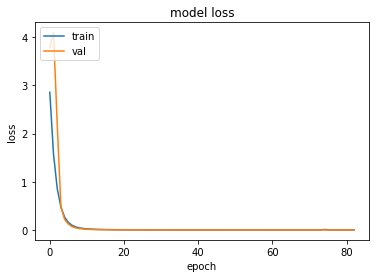

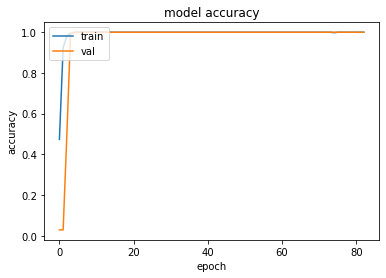

In [16]:
print('Plots')
plt.plot(history_const.history['loss'])
plt.plot(history_const.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('F:/VA/onehandtwohand/26words_DSLR_results/'+model_name1+'_loss.png')
plt.savefig(load_path+model_name1+'_loss.png')
plt.show()
plt.plot(history_const.history['accuracy'])
plt.plot(history_const.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(load_path+model_name1+'_accuracy.png')
plt.show()

In [17]:
print('Confusion matrix')
Y_pred = model1.predict(X_new)
y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new, axis=1)

cm=metrics.confusion_matrix(y_test1, y_pred)


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (200, 100)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig(load_path+model_name1+'_cm.png',bbox_inches='tight')
plt.show()


Confusion matrix
91/91 [==============================] - 5s 31ms/step


In [ ]:
#PLot fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(np.arange(cat_len), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(cat_len), CATEGORIES)
plt.savefig(load_path+model_name1+'_incorrect_percentage.png',bbox_inches='tight')
plt.show()

In [ ]:
#CHECK RANDOM IMAGES FROM TESTED DATA WHETHER RIGHT OR WRONG

i = random.randint(1,cat_len)
plt.imshow(X_new[i,:,:,2]) 
print("Predicted Label: ", CATEGORIES[int(y_pred[i])])
print("True Label: ", CATEGORIES[int(y_test1[i])])

# Colourful mediapipe testing with VA_create_3.0

In [18]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def landmarks(img,results):
      
# hands
    for hand_landmarks in results.multi_hand_landmarks:

        mp_drawing.draw_landmarks(
          img,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())

In [19]:
## For veryyyyyyyy beautiful webcam input:

cap = cv2.VideoCapture(0)
org = (20, 20)  
org1 = (310, 20) 
fontScale = 0.65  
font = cv2.FONT_HERSHEY_SIMPLEX
# Blue color in BGR
color = (130, 0, 0)  
# Line thickness of 2 px
thickness = 1 
thickness1 = -1
start_point = (0,0)
end_point = (480,30)
color1 = (255, 255, 255)  

with mp_hands.Hands(static_image_mode=False,max_num_hands=1,min_detection_confidence=0.5) as hands:
    while cap.isOpened():
        #image from feeder
        r, img_array = cap.read()
        img_array = cv2.flip(img_array, 1)
        img_array = img_array[:, 80:560, :]
        #to show
        results = hands.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        
        
        
        if not results.multi_hand_landmarks:  # exclude saving no hands
            continue
        landmarks(img_array, results)
        # to predict
        img = np.zeros([480,480,3],dtype=np.uint8)
        img.fill(255) 
        landmarks(img,results) # from function
        
        # for prediction
        IMG_SIZE=128
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        X = X.astype('float32')
        X /= 255
        X = np.array(X)
        Y = model1.predict(X,verbose=0)
        #to dhoe
        if np.max(Y)>0.2:
            # for display
            image = cv2.rectangle(img, start_point, end_point, color1, thickness1)
            image = cv2.rectangle(image, (0,30), (480,30), color, 2)
#             image = cv2.putText(image,"Prediction: "+ CATEGORIES[np.argmax(Y)], org, font, 
#                    fontScale, color, thickness, cv2.LINE_AA)
            image = cv2.putText(image, CATEGORIES[np.argmax(Y)], org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            image = cv2.putText(image,"Accuracy: "+ "%.2f" % np.max(Y), org1, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            if np.max(Y)>0.95:
                cv2.imwrite(load_path+'/15layer_massey128_test_images/'+CATEGORIES[np.argmax(Y)]
                            +"--"+str(np.max(Y))+'.jpg',image)


        cv2.imshow('Realtime testing', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
                break
# close the camera
cap.release()

# close all the opened windows
cv2.destroyAllWindows()